In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import dandelion as ddl
sc.logging.print_header()

warnings.filterwarnings('ignore')
os.chdir('/lustre/scratch117/cellgen/team297/kt16/Ziad/scanpy')

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.19.4 scipy==1.6.0 pandas==1.2.3 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 leidenalg==0.8.3


In [2]:
rnax1 = sc.read_h5ad('h5ad/R/MNP_1.5_prep_milo.h5ad')
rnax2 = sc.read_h5ad('h5ad/R/MNP_2.5_prep_milo.h5ad')

In [3]:
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging

In [4]:
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [5]:
anndata2ri.activate()

In [6]:
%load_ext rpy2.ipython

In [7]:
%%R -o dares1 -o dares2
mylox1 <- readRDS('h5ad/R/milo_MNP_1.5.RDS')
mylox2 <- readRDS('h5ad/R/milo_MNP_2.5.RDS')
dares1 <- readRDS('h5ad/R/model_1/milo_results_1.5vsuntreated_MNP.RDS')
dares2 <- readRDS('h5ad/R/model_1/milo_results_2.5vsuntreated_MNP.RDS')

In [8]:
%%R -o nhood_graph1 -o nhood_graph2
library(miloR)
library(igraph)
library(SingleCellExperiment)
## Save the adjacency matrix of the nhood graph
nhood_graph1 = as_adjacency_matrix(nhoodGraph(mylox1), attr="weight")
nhood_graph2 = as_adjacency_matrix(nhoodGraph(mylox2), attr="weight")

In [9]:
%%R -o nh_umap_df1 -o nh_umap_df2
## Save the positions in UMAP of nhood indices
nh_umap_df1 = reducedDim(mylox1, "UMAP")[unlist(nhoodIndex(mylox1)),]
nh_umap_df2 = reducedDim(mylox2, "UMAP")[unlist(nhoodIndex(mylox2)),]

In [10]:
nhood_adata1 = sc.AnnData(obs = dares1)
nhood_adata2 = sc.AnnData(obs = dares2)

In [11]:
## Add graph
nhood_graph_conn1 = nhood_graph1.copy()
nhood_graph_conn1[nhood_graph_conn1 > 1] = 1 

nhood_adata1.uns["neighbors"] = {}
nhood_adata1.obsp['distances'] = nhood_graph1
nhood_adata1.uns['neighbors']["distances"] = nhood_graph1
nhood_adata1.obsp['connectivities'] = nhood_graph_conn1
nhood_adata1.uns['neighbors']["connectivities"] = nhood_graph_conn1

nhood_graph_conn2 = nhood_graph2.copy()
nhood_graph_conn2[nhood_graph_conn2 > 1] = 1 

nhood_adata2.uns["neighbors"] = {}
nhood_adata2.obsp['distances'] = nhood_graph2
nhood_adata2.uns['neighbors']["distances"] = nhood_graph2
nhood_adata2.obsp['connectivities'] = nhood_graph_conn2
nhood_adata2.uns['neighbors']["connectivities"] = nhood_graph_conn2

In [12]:
## Add umap positions
nhood_adata1.obsm["X_umap"] = nh_umap_df1
nhood_adata2.obsm["X_umap"] = nh_umap_df2

In [13]:
nhood_adata1

AnnData object with n_obs × n_vars = 1713 × 0
    obs: 'Nhood', 'beta', 'PValue', 'SpatialFDR', 'Diff'
    uns: 'neighbors'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

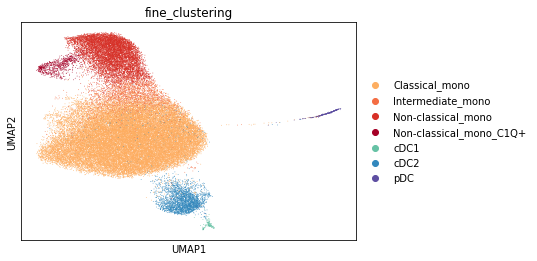

In [14]:
sc.pl.umap(rnax1, color = 'fine_clustering')

In [15]:
nhood_adata1.obs["beta_signif"] = nhood_adata1.obs["beta"]
nhood_adata1.obs["beta_signif"][nhood_adata1.obs["SpatialFDR"] > 0.1] = np.nan
nhood_adata2.obs["beta_signif"] = nhood_adata2.obs["beta"]
nhood_adata2.obs["beta_signif"][nhood_adata2.obs["SpatialFDR"] > 0.1] = np.nan

In [16]:
from tools import diverging_cmp, get_hex

In [17]:
# newcmp = diverging_cmp(get_hex('cool', 5)[0], get_hex('cool', 5)[4])

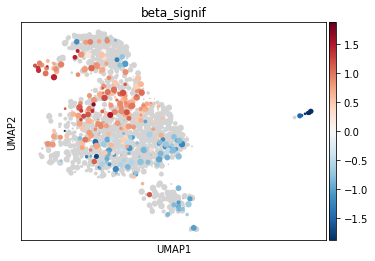

In [18]:
ax = sc.pl.umap(nhood_adata1, show = False, size = 1)
sc.pl.umap(nhood_adata1, color="beta_signif", cmap='RdBu_r', size = [x*.1 for x in nhood_adata1.obs['Nhood']], ax = ax, vmax = np.nanmax(nhood_adata2.obs['beta_signif']), vmin = -np.nanmax(nhood_adata2.obs['beta_signif']))

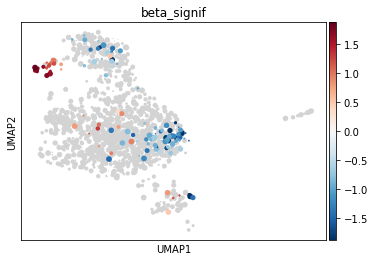

In [19]:
ax = sc.pl.umap(nhood_adata2, show = False, size = 1)
sc.pl.umap(nhood_adata2, color="beta_signif", cmap='RdBu_r', size = [x*.1 for x in nhood_adata2.obs['Nhood']], ax = ax, vmax = np.nanmax(nhood_adata2.obs['beta_signif']), vmin = -np.nanmax(nhood_adata2.obs['beta_signif']))